In [42]:
# importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Conv1D, Embedding, Input, Dense, merge, Reshape, Flatten, Dropout, Concatenate, Multiply #Merge
from tensorflow.keras.optimizers import Adam
from time import time

import warnings
warnings.filterwarnings('ignore')

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# loading the dataframe
df_main = pd.read_csv('/content/drive/My Drive/sample30.csv')

### Data Cleaning:

In [45]:
# filtering-in required columns
df_reco = df_main[['name','reviews_username','reviews_rating']]

In [46]:
# check for null values

df_reco.isnull().sum()

name                 0
reviews_username    63
reviews_rating       0
dtype: int64

In [47]:
# dropping rows with NaN values

df_reco.dropna(axis=0, inplace=True)

In [48]:
# check for duplicates

df_reco.duplicated().sum()

2198

In [49]:
# dropping the duplicates

df_reco.drop_duplicates(inplace=True)

In [50]:
# check for duplicates based on subset of 'name' and 'reviews_username'

df_reco.duplicated(subset=['name','reviews_username']).sum()

151

From above we note that we have certain users who have given two or more different ratings to the same products. Let us impute those ratings the average ratings.

In [51]:
# get the average ratings for duplicated rows

df_mean = df_reco[df_reco.duplicated(subset=['name','reviews_username'], keep=False)].groupby(
    by=['name', 'reviews_username']).mean()

df_mean

reviews_rating
name                                               reviews_username                 
100:Complete First Season (blu-Ray)                dontdodat                3.500000
Alex Cross (dvdvideo)                              mookie                   4.500000
Aveeno Baby Continuous Protection Lotion Sunscr... byamazon customer        2.666667
Avery174 Ready Index Contemporary Table Of Cont... gellis                   4.500000
                                                   the office guro          3.500000
...                                                                              ...
Tostitos Bite Size Tortilla Chips                  debb                     4.000000
                                                   rick                     4.500000
                                                   sandy                    3.000000
Windex Original Glass Cleaner Refill 67.6oz (2 ... laura                    1.500000
                                                   suri                     3.500000

[135 rows x 1 columns]

In [52]:
# left merge the df_reco and df_mean dataframes over 'name' and 'reviews_username'

df_merged = df_reco.merge(df_mean, how='left' , on=['name', 'reviews_username']).sort_values(
    by=['name', 'reviews_username'])

df_merged.head()

,name,reviews_username,reviews_rating_x,reviews_rating_y
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3,NaN
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5,NaN
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5,NaN
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3,NaN
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5,NaN


In [53]:
df_merged.isnull().sum()

name                    0
reviews_username        0
reviews_rating_x        0
reviews_rating_y    27453
dtype: int64

Since we have very few such rows, we would have many NaN values in reviews_rating_y column. Let us concatenate the dataframe such that we get average values from reviews_rating_y column and normal ratings from reviews_rating_x column

In [54]:
A = df_merged[df_merged['reviews_rating_y'].isnull()][['name','reviews_username','reviews_rating_x']]
A.rename(columns={'reviews_rating_x':'reviews_rating_final'}, inplace=True)

B = df_merged[df_merged['reviews_rating_y'].isnull()==False][['name','reviews_username','reviews_rating_y']]
B.rename(columns={'reviews_rating_y':'reviews_rating_final'}, inplace=True)

df_final= pd.concat([A, B])
df_final.sort_values(by=['name', 'reviews_username'])

,name,reviews_username,reviews_rating_final
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3.0
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5.0
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5.0
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3.0
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5.0
...,...,...,...
20525,Yes To Grapefruit Rejuvenating Body Wash,sheila,1.0
20534,Yes To Grapefruit Rejuvenating Body Wash,skeel,4.0
20531,Yes To Grapefruit Rejuvenating Body Wash,td33,3.0
20553,Yes To Grapefruit Rejuvenating Body Wash,trishaxo2u,5.0


In [55]:
# check for duplicates from `df_final` df
df_final.duplicated().sum()

151

In [56]:
# drop duplicates from 'df_final' df

df_final.drop_duplicates(inplace=True)

In [57]:
df_final.head()

,name,reviews_username,reviews_rating_final
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3.0
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5.0
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5.0
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3.0
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5.0


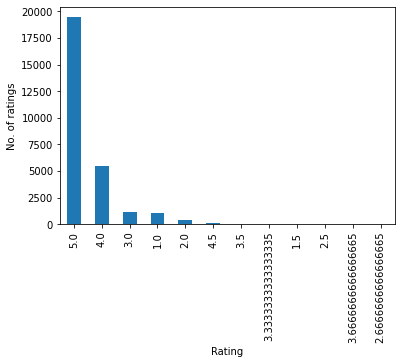

In [58]:
df_final['reviews_rating_final'].value_counts().plot.bar()
plt.xlabel('Rating')
plt.ylabel('No. of ratings')
plt.show()

In [59]:
df_final.duplicated().sum()

0

### Data Preparation:

In [60]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(df_final, test_size=0.2, random_state=32)

print(Train.shape)
print(Test.shape)

(22070, 3)
(5518, 3)


We would only be able to test those users and items which are already in our database (Train set). So let's filter-in such common entries and prepare our Test set. 

In [61]:
Test = Test[(Test.name.isin(Train.name)) & (Test.reviews_username.isin(Train.reviews_username))]
print(Test.shape)

(779, 3)


----------------------------------------------------------------------------------------------

In [62]:
# data preparation 
from sklearn.preprocessing import LabelEncoder

le_user = LabelEncoder()
le_user.fit(Train['reviews_username'])
user_enc = le_user.transform(Train['reviews_username'])
user_enc_test = le_user.transform(Test['reviews_username'])


le_name = LabelEncoder()
le_name.fit(Train['name'])
name_enc = le_name.transform(Train['name'])
name_enc_test = le_name.transform(Test['name'])

### Neural Matrix Factorization Method:

In [63]:
# def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
#     assert len(layers) == len(reg_layers)
#     num_layer = len(layers) #Number of layers in the MLP
#     # Input variables
#     user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
#     item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
#     # Embedding layer
#     MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
#                                   embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_mf), input_length=1)
#     MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
#                                   embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_mf), input_length=1)
 

#     MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = 5, name = 'mlp_embedding_user',
#                                   embeddings_initializer = 'uniform', embeddings_regularizer =  l2(reg_layers[0]), input_length=1)
    
#     MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = 5, name = 'mlp_embedding_item',
#                                   embeddings_initializer = 'uniform', embeddings_regularizer =  l2(reg_layers[0]), input_length=1)
      
    
#     # MF part
#     mf_user_latent = Flatten()(MF_Embedding_User(user_input))
#     mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
#     mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

#     # MLP part 
#     mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
#     mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
#     mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent]) # concatenation
#     for idx in range(num_layer):
#         layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
#         mlp_vector = layer(mlp_vector)

#     # Concatenate MF and MLP parts
#     predict_vector = Concatenate()([mf_vector, mlp_vector])
    
#     # Final prediction layer
#     prediction = Dense(1, activation=None, kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
#     model = Model(inputs=[user_input, item_input], 
#                   outputs=prediction)
    
#     return model

In [64]:
# print('Unique users in database(Train)=',Train.reviews_username.nunique())
# print('Unique items in database(Train)=', Train.name.nunique())

In [65]:
# # defining model
# model = get_model(num_users=Train.reviews_username.nunique(),
#                   num_items=Train.name.nunique(),
#                   mf_dim=64, 
#                   layers=[50,40,30,20,10], 
#                   reg_layers=[50*1e-4, 40*1e-4, 30*1e-4, 20*1e-4, 10*1e-4], 
#                   reg_mf=10*1e-4)

In [66]:
# # checking model summary
# model.summary()

In [67]:
# # compiling the model
# model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [68]:
# # training the model
# model.fit([user_enc, name_enc], #input
#           np.array(Train['reviews_rating_final']), # labels 
#           batch_size=10, 
#           epochs=5, 
#           verbose=1, 
#           shuffle=True)

#### NeuMF Model Evaluation:

In [69]:
# NeuMF_pred = model.predict([user_enc_test, name_enc_test])

In [70]:
# se = 0
# count = 0
# for actual,prediction in zip(Test.reviews_rating_final.values,NeuMF_pred):
#     se += (actual - prediction)**2
#     count+=1

# mse = se/count
# print(mse)
# print(count)

In [71]:
# layers_choice = [50,40,30,20,10]
# mse_save = []

# for epoch_ in range(10,110,10):
#   # layer_cust = layers_choice[:i+1]
#   # reg_layers_cust = [10*1e-4]*(i+1)
#   # print(layer_cust)
#   # print(reg_layers_cust)
#   # defining model
#   model = get_model(num_users=Train.reviews_username.nunique(),
#                     num_items=Train.name.nunique(),
#                     mf_dim=64, 
#                     layers= [50,40,30,20,10] #layer_cust, 
#                     reg_layers= [10*1e-4]*(5) # reg_layers_cust, 
#                     reg_mf=10*1e-4)

#   # checking model summary
#   # model.summary()

#   # compiling the model
#   model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

#   # training the model
#   model.fit([user_enc, name_enc], #input
#             np.array(Train['reviews_rating_final']), # labels 
#             batch_size=512, 
#             epochs=epoch_, 
#             verbose=1, 
#             shuffle=True)

#   NeuMF_pred = model.predict([user_enc_test, name_enc_test])

#   se = 0
#   count = 0
#   for actual,prediction in zip(Test.reviews_rating_final.values,NeuMF_pred):
#       se += (actual - prediction)**2
#       count+=1

#   mse = se/count
#   mse_save.append(mse)



In [72]:
# mse_save

----------------------------------------------------------------------------------------------------

### Outer Product-based Neural Collaborative Filtering:

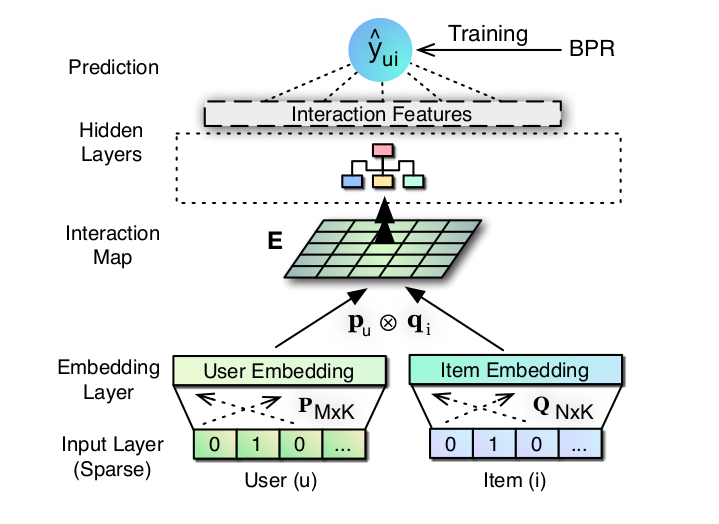

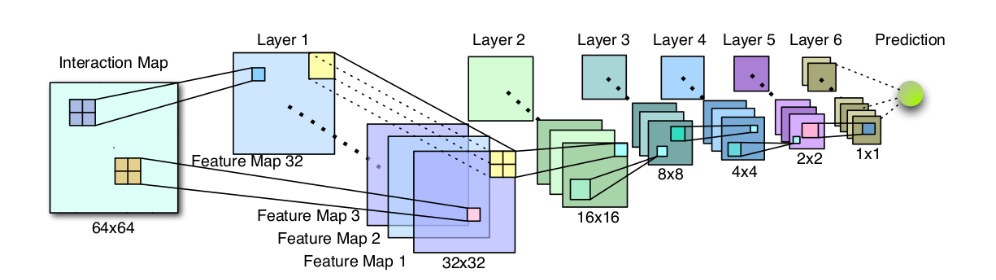

From above, we note that NeuMF method is giving superior result (on Test dataset) with MSE = 0.62 as compared with MF method with MSE = 1.52.

In [73]:
def get_OPNCF_model(num_users, num_items, mf_dim=64, layers=[32,32,32,32,32,32], 
                    reg_layers=[0,0,0,0,0,0], reg_mf=0):
    
    assert len(layers) == len(reg_layers)
    
    #Number of layers in the ConvNCF
    num_layer = len(layers) 
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    Embedding_User = Embedding(input_dim = num_users, 
                                  output_dim = mf_dim, 
                                  name = 'mf_embedding_user',
                                  embeddings_initializer = 'uniform', 
                                  embeddings_regularizer = l2(reg_mf), 
                                  input_length=1)
    Embedding_Item = Embedding(input_dim = num_items, 
                                  output_dim = mf_dim, 
                                  name = 'mf_embedding_item',
                                  embeddings_initializer = 'uniform', 
                                  embeddings_regularizer = l2(reg_mf), 
                                  input_length=1)
     
    
    # ConvNCF input build-up
    convncf_user_latent = Flatten()(Embedding_User(user_input))
    convncf_item_latent = Flatten()(Embedding_Item(item_input)) 

#     conv_feed = np.zeros((mf_dim, mf_dim))
    
#     i = 0
#     for u in convncf_user_latent.numpy():
#         conv_feed[i,:] = keras.layers.Multiply()([u, convncf_item_latent])
#         i+=1
        
    batchSize = K.shape(convncf_user_latent)[0]
    # print('batchSize',batchSize)
    outerProduct = convncf_user_latent[:,:, np.newaxis] * convncf_item_latent[:,np.newaxis,:]
    # print('outerProduct',outerProduct.shape)
#     outerProduct = K.reshape(outerProduct, (batchSize, -1))
    
    conv_feed = outerProduct
    
    # print(conv_feed.shape)
    
    # ConvNCF part 
    for idx in range(num_layer):
        layer = Conv1D(
                       filters=layers[idx], 
                       kernel_size=2,
                       strides=2,
                       activation='relu',
                       padding='valid',
                       kernel_regularizer = l2(reg_layers[idx]), 
                       name="layer%d" %idx,
                       input_shape = (mf_dim,mf_dim)
                       )
        conv_feed = layer(conv_feed)
    
    conv_feed = Flatten()(conv_feed)
    # Final prediction layer
    prediction = Dense(1, 
                       activation=None, 
                       kernel_initializer='lecun_uniform', 
                       name = "prediction")(conv_feed)
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=prediction)
    
    return model

In [74]:
print('Unique users in database(Train)=',Train.reviews_username.nunique())
print('Unique items in database(Train)=', Train.name.nunique())

Unique users in database(Train)= 20232
Unique items in database(Train)= 258


In [75]:
# # defining model
# model = get_OPNCF_model(num_users=Train.reviews_username.nunique(),
#                   num_items=Train.name.nunique(),
#                   mf_dim=64, 
#                   layers=[32,32,32,32,32,32], 
#                   reg_layers=[60*1e-4, 50*1e-4, 40*1e-4, 30*1e-4, 20*1e-4, 10*1e-4], 
#                   reg_mf=0)

In [76]:
# # checking model summary
# model.summary()

In [77]:
# # compiling the model
# model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [78]:
# # training the model
# model.fit([user_enc, name_enc], #input
#           np.array(Train['reviews_rating_final']), # labels 
#           batch_size=10, 
#           epochs=5, 
#           verbose=1, 
#           shuffle=True)

 #### ConvNCF Model Evaluation:

In [79]:
# ConvNCF_pred = model.predict([user_enc_test, name_enc_test])

In [80]:
# se = 0
# count = 0
# for actual,prediction in zip(Test.reviews_rating_final.values, ConvNCF_pred):
#     se += (actual - prediction)**2
#     count+=1

# mse = se/count
# print(mse)
# print(count)

In [81]:
mes_list = []

for epoch_ in range(50,310,50):
  # layer_val = [32]*i
  # reg_layer_val = [0.0001]*i
  # defining model
  model = get_OPNCF_model(num_users=Train.reviews_username.nunique(),
                    num_items=Train.name.nunique(),
                    mf_dim=64, 
                    layers=[32,32,32,32,32,32],
                    reg_layers=[10*1e-4]*6, 
                    reg_mf=0)

  # checking model summary
  # model.summary()

  # compiling the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

  # training the model
  model.fit([user_enc, name_enc], #input
            np.array(Train['reviews_rating_final']), # labels 
            batch_size=512, 
            epochs=epoch_, 
            # verbose=1, 
            shuffle=True)

  # predicting
  ConvNCF_pred = model.predict([user_enc_test, name_enc_test])

  # evaluating
  se = 0
  count = 0
  for actual,prediction in zip(Test.reviews_rating_final.values, ConvNCF_pred):
      se += (actual - prediction)**2
      count+=1

  mse = se/count
  # print(mse)
  mes_list.append(mse)

Epoch 1/50
44/44 [==============================] - 3s 51ms/step - loss: 13.3530
Epoch 2/50
44/44 [==============================] - 2s 51ms/step - loss: 1.1416
Epoch 3/50
44/44 [==============================] - 2s 50ms/step - loss: 0.8849
Epoch 4/50
44/44 [==============================] - 2s 50ms/step - loss: 0.5485
Epoch 5/50
44/44 [==============================] - 2s 51ms/step - loss: 0.3498
Epoch 6/50
44/44 [==============================] - 2s 50ms/step - loss: 0.2124
Epoch 7/50
44/44 [==============================] - 2s 51ms/step - loss: 0.1325
Epoch 8/50
44/44 [==============================] - 2s 51ms/step - loss: 0.1054
Epoch 9/50
44/44 [==============================] - 2s 52ms/step - loss: 0.0940
Epoch 10/50
44/44 [==============================] - 2s 52ms/step - loss: 0.0860
Epoch 11/50
44/44 [==============================] - 2s 52ms/step - loss: 0.0805
Epoch 12/50
44/44 [==============================] - 2s 52ms/step - loss: 0.0765
Epoch 13/50
44/44 [=================

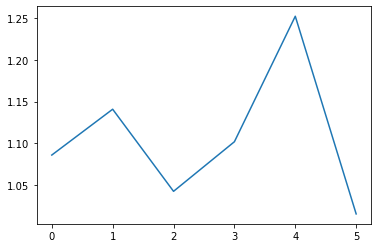

In [82]:
mes_list

import matplotlib.pyplot as plt

plt.plot(mes_list)